# Transfer Learning

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import PIL

from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory

In [ ]:
dataset_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url,extract=True)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [ ]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

batch_size = 32
img_size = (160,160)

train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle = True,
    batch_size=batch_size,
    image_size = img_size
)

Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  image_size=img_size)

Found 1000 files belonging to 2 classes.


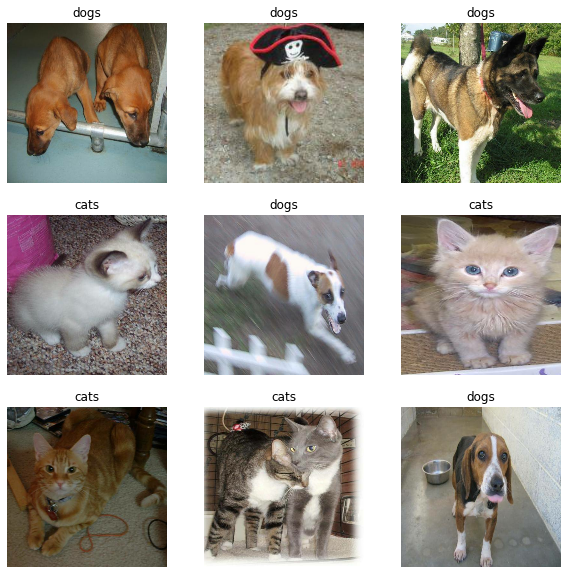

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax= plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print(class_names)

['cats', 'dogs']


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


# Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(160,160,3)),
      keras.layers.experimental.preprocessing.RandomRotation(0.2),
      keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [ ]:
data_augmentation.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 160, 160, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 160, 160, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 160, 160, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


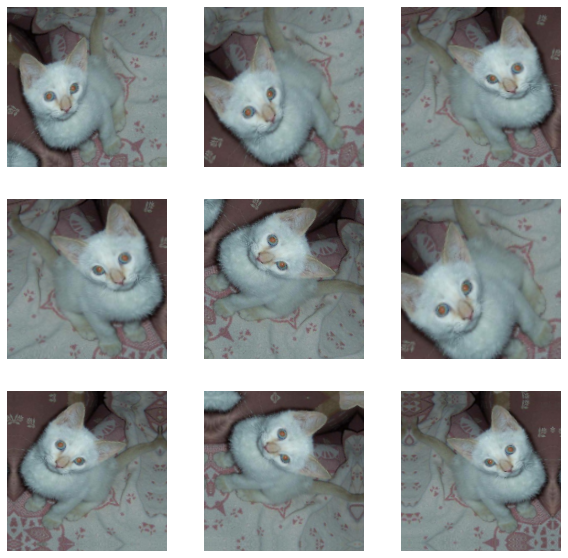

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Preprocessing code (use this later)

In [ ]:
# The model MobileNetV2 expects the pixel values in [-1,1] but we have those
# in [0,255] so we are going to change them

preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Alternate preprocessing code
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Develop the base model from MobileNet V2

In [ ]:
img_shape = img_size + (3,)
base_model = keras.applications.MobileNetV2(input_shape=img_shape,
                                            include_top=False,
                                            weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Feature Extraction

### Freeze the convolutional base 

In [ ]:
# Currently freezing all the layers
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### In the above model the non-trainable parameters are full cause we have freezed all the layers

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


# Adding classification layers

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model

In [ ]:
lr = 0.0001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
# There are 2 td.variable objects: weights and biases
len(model.trainable_variables)

2

# Train Model

In [ ]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 54ms/step - loss: 0.6935 - accuracy: 0.5767


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.58


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/15
63/63 [==============================] - 9s 102ms/step - loss: 0.6662 - accuracy: 0.6165 - val_loss: 0.4786 - val_accuracy: 0.7277
Epoch 2/15
63/63 [==============================] - 6s 91ms/step - loss: 0.5295 - accuracy: 0.7180 - val_loss: 0.3582 - val_accuracy: 0.8181
Epoch 3/15
63/63 [==============================] - 6s 91ms/step - loss: 0.4240 - accuracy: 0.7845 - val_loss: 0.2858 - val_accuracy: 0.8663
Epoch 4/15
63/63 [==============================] - 6s 90ms/step - loss: 0.3627 - accuracy: 0.8200 - val_loss: 0.2328 - val_accuracy: 0.9010
Epoch 5/15
63/63 [==============================] - 6s 89ms/step - loss: 0.3135 - accuracy: 0.8465 - val_loss: 0.1992 - val_accuracy: 0.9282
Epoch 6/15
63/63 [==============================] - 6s 90ms/step - loss: 0.2899 - accuracy: 0.8670 - val_loss: 0.1780 - val_accuracy: 0.9369
Epoch 7/15
63/63 [==============================] - 6s 90ms/step - loss: 0.2656 - accuracy: 0.8740 - val_loss: 0.1684 - val_accuracy: 0.9356
Epoch 8/15
6

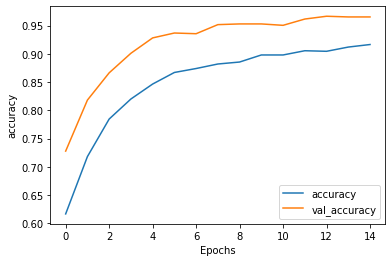

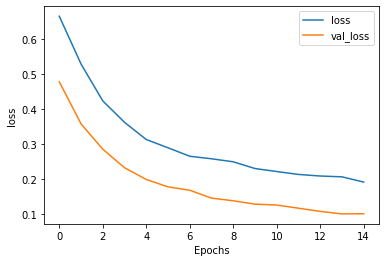

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(history, word):
  plt.plot(history.history[word])
  plt.plot(history.history['val_'+word])
  plt.xlabel('Epochs')
  plt.ylabel(word)
  plt.legend([word, 'val_'+ word])
  plt.show()

plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

# Fine Tuning

In [ ]:
# Make all the layers trainable
base_model.trainable = True

In [ ]:
# Total number of layers in the base model
print("Number of layers in base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False 

Number of layers in base model:  154


# Compile the tuned model

In [ ]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = keras.optimizers.RMSprop(lr = lr/10),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

56

# Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs 

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 15/25
63/63 [==============================] - 11s 111ms/step - loss: 0.1860 - accuracy: 0.9153 - val_loss: 0.0549 - val_accuracy: 0.9851
Epoch 16/25
63/63 [==============================] - 7s 99ms/step - loss: 0.1157 - accuracy: 0.9594 - val_loss: 0.0432 - val_accuracy: 0.9876
Epoch 17/25
63/63 [==============================] - 7s 99ms/step - loss: 0.1100 - accuracy: 0.9573 - val_loss: 0.0396 - val_accuracy: 0.9889
Epoch 18/25
63/63 [==============================] - 7s 99ms/step - loss: 0.1182 - accuracy: 0.9537 - val_loss: 0.0461 - val_accuracy: 0.9889
Epoch 19/25
63/63 [==============================] - 7s 100ms/step - loss: 0.0877 - accuracy: 0.9667 - val_loss: 0.0418 - val_accuracy: 0.9839
Epoch 20/25
63/63 [==============================] - 7s 100ms/step - loss: 0.1105 - accuracy: 0.9527 - val_loss: 0.0399 - val_accuracy: 0.9814
Epoch 21/25
63/63 [==============================] - 6s 99ms/step - loss: 0.0916 - accuracy: 0.9667 - val_loss: 0.0417 - val_accuracy: 0.9802
Ep

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

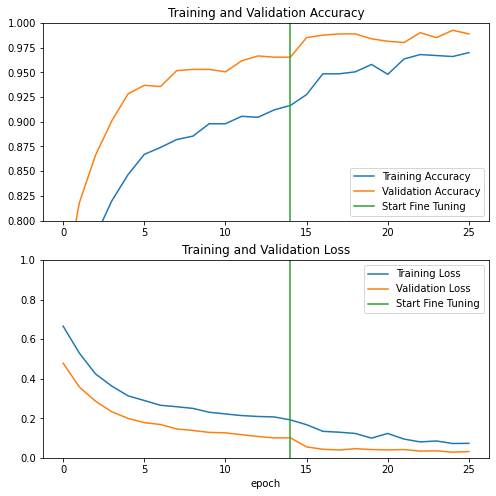

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation and Prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 71ms/step - loss: 0.0533 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


This image most likely belongs to cats with a 100.00 percent confidence.


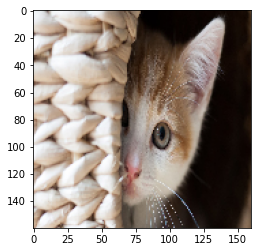

In [ ]:
cat1_url = 'https://www.humanesociety.org/sites/default/files/styles/1240x698/public/2018/08/kitten-440379.jpg?h=c8d00152&itok=1fdekAh2'
cat1_path = keras.utils.get_file('Cats',origin=cat1_url)

img = keras.preprocessing.image.load_img(
    cat1_path, target_size=(img_size)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

plt.imshow(img)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Predictions:
 [0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1]
Labels:
 [0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1]


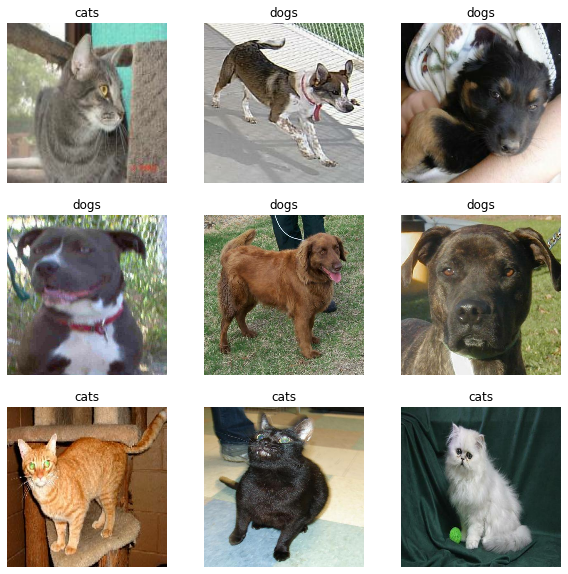

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")